# Classification using Neural Networks with PyTorch

In this case, instead of predicting a line or number, the aim is to predict a label among two or more labels

## Architecture of a classification Neural Network

| **Hyperparameter**                  | **Binary classification**                | **Multiclass classification**               |
|-------------------------------------|------------------------------------------|---------------------------------------------|
|**Input layer shape** (`in_features`)   | Number of features                       | Same                                        |
| **Hidden layers**                       | Problem specific, minimum = 1            | Same                                        |
| **Output layer shape** (`out_features`) | 1 (on class or another)                  | 1 per class                                 |
| **Hidden layer activation**             | Usually ReLU                             | Same                                        |
| **Output activation**                   | Sigmoid (`torch.sigmod`)                 | Softmax (`torch.softmax`)                   |
| **Loss function**                       | Binary crossentropy (`torch.nn.BCELoss`) | Cross entropy (`torch.nn.CrossEntropyLoss`) |
| **Optimizer**                           | SGD, Adam                                | Same                                        |




## 1. Make classification data and get it ready

In [91]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [92]:
X.shape, y.shape

((1000, 2), (1000,))

In [93]:
# Make DataFrame

import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


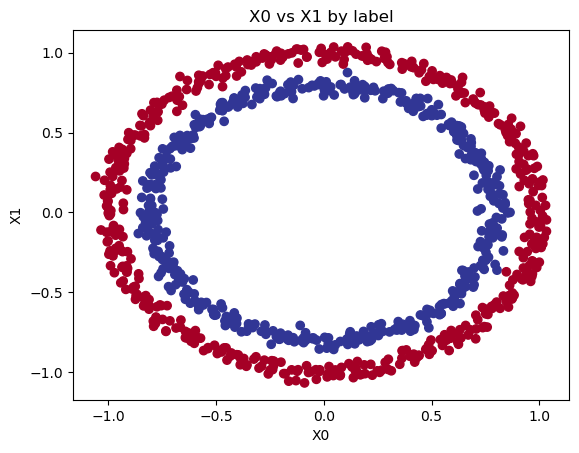

In [94]:
# @title X0 vs X1 by label

import matplotlib.pyplot as plt
plt.scatter(circles['X0'], circles['X1'], c=circles['label'], cmap=plt.cm.RdYlBu)
plt.xlabel('X0')
plt.ylabel('X1')
_ = plt.title('X0 vs X1 by label')

### 1.1 Check input and output shapes

In [95]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train/test split

In [96]:
import torch
torch.__version__

'2.2.2'

In [97]:
# Truning arrays into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Build model

To build the model, we need to:
1. Setup device agnostic code so our code will run on GPU if available
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training loop and testing loop

In [99]:
from torch import nn

In [100]:
# Set device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [101]:
# This allows to build more complex networks
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes 2 feature inputs (X), produces 5 features
        self.layer2 = nn.Linear(in_features=5, out_features=1) # takes 5 feaures, produces 1 output (y)

    def forward(self, x: torch.Tensor):
        return self.layer2(self.layer1(x))

In [102]:
model_0 = ClassificationModel().to(device)
model_0

ClassificationModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [103]:
# Build model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [104]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4903, -0.4090],
                      [-0.2408, -0.3570],
                      [-0.3259,  0.6178],
                      [-0.6463,  0.6007],
                      [-0.4037,  0.5013]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3974,  0.7004,  0.5414,  0.4483,  0.2845], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2869, -0.3606,  0.0771, -0.2681,  0.2580]], device='cuda:0')),
             ('1.bias', tensor([0.4148], device='cuda:0'))])

In [105]:
# Set data to available device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [106]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nLength of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {X_test[:10]}")
print(f"\nFirst 10 labels: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])

Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]], device='cuda:0')

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [107]:
## Setup loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [108]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))
    return acc

## 3. Train model

Set up training loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Backpropagation
5. Optimizer step (Gradient Descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these logits into prediction probabilites by passing them to some kind of activation function (e.g sigmoid for binary corss entropy and softmax for multiclass classification).

Then we can convert our models predictions probabilites to **prediction labels** by either rounding them or taking the `argmax()`

In [109]:
# View the first 5 outpust of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits =  model_0(X_test)[:5]
y_logits

tensor([[0.4538],
        [0.5227],
        [0.1957],
        [0.5273],
        [0.0724]], device='cuda:0')

In [110]:
# Use sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6115],
        [0.6278],
        [0.5488],
        [0.6289],
        [0.5181]], device='cuda:0')

In [111]:
y_pred = y_pred_probs.round()
y_pred

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [112]:
# In full (logits -> prob -> label)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

#Check for equality
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dims
y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### 3.2 Building training/test loop

In [113]:
# Training loop

epoch_count = []
loss_values = []
test_loss_values = []

# Train model for 300 epochs
epochs = 300

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logit -> prob -> label

  # 2. Calculate loss
  loss = loss_function(y_logits, # BCEWithLogitLoss expects logits as inputs.
                        y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Zero gradients
  model_0.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 20 == 0:

    # Put model in evaluation mode and setup inference context
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))
      # 2. Calculate test loss
      test_loss = loss_function(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train Acc: {acc:.2f} | Test loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train loss: 0.70410 | Train Acc: 0.51 | Test loss: 0.712 | Test Acc: 0.50
Epoch: 20 | Train loss: 0.70161 | Train Acc: 0.55 | Test loss: 0.709 | Test Acc: 0.54
Epoch: 40 | Train loss: 0.69971 | Train Acc: 0.58 | Test loss: 0.707 | Test Acc: 0.56
Epoch: 60 | Train loss: 0.69827 | Train Acc: 0.59 | Test loss: 0.705 | Test Acc: 0.55
Epoch: 80 | Train loss: 0.69717 | Train Acc: 0.56 | Test loss: 0.704 | Test Acc: 0.52
Epoch: 100 | Train loss: 0.69634 | Train Acc: 0.55 | Test loss: 0.703 | Test Acc: 0.51
Epoch: 120 | Train loss: 0.69571 | Train Acc: 0.54 | Test loss: 0.702 | Test Acc: 0.51
Epoch: 140 | Train loss: 0.69523 | Train Acc: 0.53 | Test loss: 0.701 | Test Acc: 0.49
Epoch: 160 | Train loss: 0.69487 | Train Acc: 0.53 | Test loss: 0.701 | Test Acc: 0.50
Epoch: 180 | Train loss: 0.69459 | Train Acc: 0.53 | Test loss: 0.701 | Test Acc: 0.48
Epoch: 200 | Train loss: 0.69437 | Train Acc: 0.53 | Test loss: 0.700 | Test Acc: 0.47
Epoch: 220 | Train loss: 0.69421 | Train Acc: 0.5

## 4. Make predictions and evaluate the model

From the metrics it seems the model isn't learning anything...

So to inspect it let's make some preditions and visualize

To do so, we're going to import a function called `plot_decision_boundary()`

In [114]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch repo (if it's not already downloaded)

if (Path("helper_functions.py").is_file()):
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


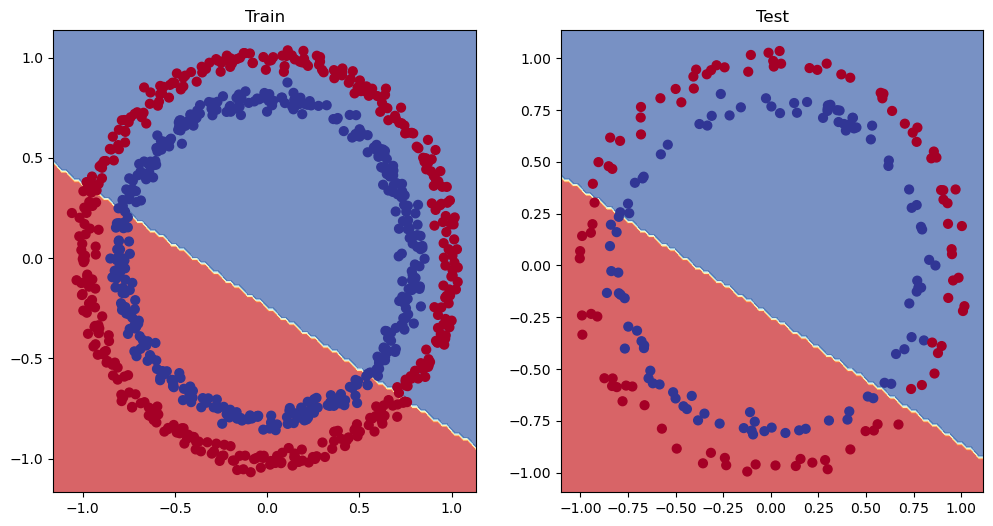

In [115]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer epochs
* Change/add the activation functions
* Change the learning rate
* Change the loss function

These options are all from our models perspective because they deal directly with the model, rather than the data.

And because all these options are all values we (as machine learning engineers and datqa scientists) can change, they are referred as **hyperparameters**.

Let's try to improve our model by 
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 300 -> 1000

In [121]:
class ClassificationModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # z = self.layer1(x)
        # z = self.layer1(z)
        # z = self.layer3(z)
        return self.layer3(self.layer2(self.layer1(x))) # this way speeds up operations

model_1 = ClassificationModelV1().to(device)
model_1

ClassificationModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [122]:
# Create loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# Create optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [123]:
# Training loop

epoch_count = []
loss_values = []
test_loss_values = []

# Train model for 300 epochs
epochs = 1000

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logit -> prob -> label

  # 2. Calculate loss
  loss = loss_function(y_logits, # BCEWithLogitLoss expects logits as inputs.
                        y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Zero gradients
  model_1.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 50 == 0:

    # Put model in evaluation mode and setup inference context
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))
      # 2. Calculate test loss
      test_loss = loss_function(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train Acc: {acc:.2f} | Test loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train loss: 0.69449 | Train Acc: 0.50 | Test loss: 0.693 | Test Acc: 0.50
Epoch: 50 | Train loss: 0.69413 | Train Acc: 0.58 | Test loss: 0.693 | Test Acc: 0.60
Epoch: 100 | Train loss: 0.69389 | Train Acc: 0.54 | Test loss: 0.693 | Test Acc: 0.60
Epoch: 150 | Train loss: 0.69372 | Train Acc: 0.52 | Test loss: 0.693 | Test Acc: 0.57
Epoch: 200 | Train loss: 0.69360 | Train Acc: 0.51 | Test loss: 0.693 | Test Acc: 0.55
Epoch: 250 | Train loss: 0.69351 | Train Acc: 0.52 | Test loss: 0.693 | Test Acc: 0.54
Epoch: 300 | Train loss: 0.69344 | Train Acc: 0.52 | Test loss: 0.693 | Test Acc: 0.53
Epoch: 350 | Train loss: 0.69338 | Train Acc: 0.51 | Test loss: 0.693 | Test Acc: 0.52
Epoch: 400 | Train loss: 0.69333 | Train Acc: 0.50 | Test loss: 0.693 | Test Acc: 0.53
Epoch: 450 | Train loss: 0.69328 | Train Acc: 0.51 | Test loss: 0.693 | Test Acc: 0.55
Epoch: 500 | Train loss: 0.69325 | Train Acc: 0.50 | Test loss: 0.693 | Test Acc: 0.54
Epoch: 550 | Train loss: 0.69321 | Train Acc: 

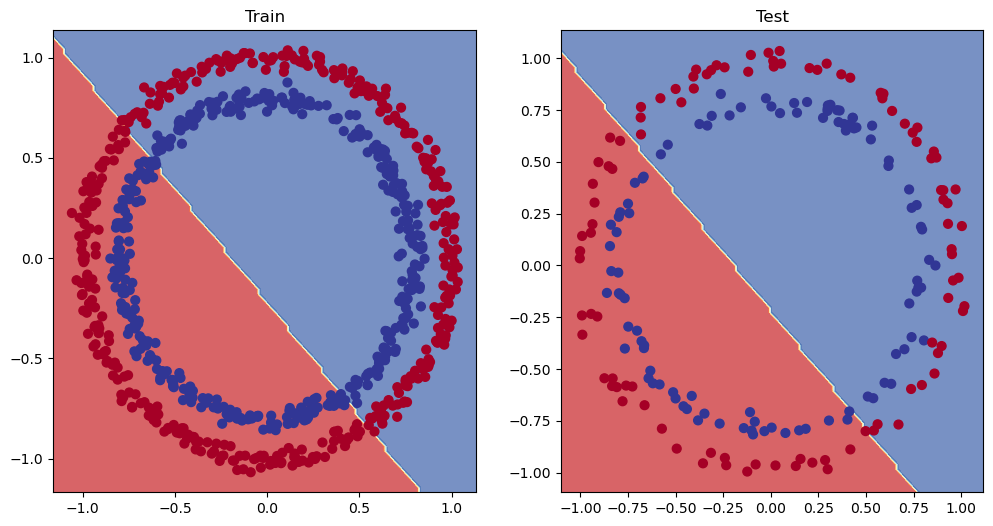

In [124]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [147]:
# Create some data (same as notebook 01)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)

y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [148]:
# Create train/test split
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


# Check lengths
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

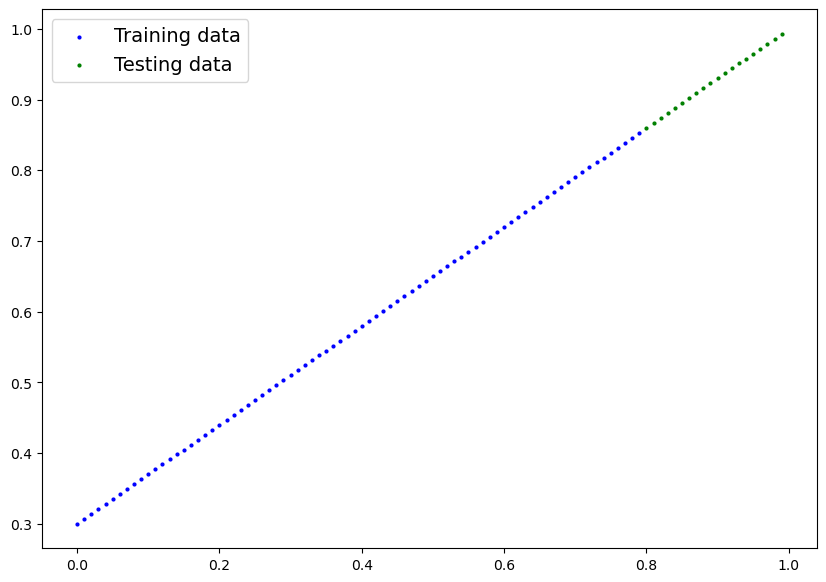

In [149]:
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [150]:
# Same architecture but using nn.Sequential()
from collections import OrderedDict
model_2 = nn.Sequential(OrderedDict([
    ('linear1', nn.Linear(in_features=1, out_features=10)),
    ('linear2', nn.Linear(in_features=10, out_features=10)),
    ('linear3', nn.Linear(in_features=10, out_features=1))
])

).to(device)

model_2

Sequential(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [151]:
# Loss function
loss_function = nn.L1Loss()
# optimizer
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [152]:
# Training loop

epoch_count = []
loss_values = []
test_loss_values = []

# Train model for 1000 epochs
epochs = 1000

# Send data to target device
X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_2.train()

  # 1. Forward pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate loss
  loss = loss_function(y_pred, y_train_regression)

  # 3. Zero gradients
  model_2.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 50 == 0:

    # Put model in evaluation mode and setup inference context
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate test loss
      test_loss = loss_function(test_pred, y_test_regression)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train Acc: {acc:.2f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.80046 | Train Acc: 0.51 | Test loss: 1.048
Epoch: 50 | Train loss: 0.05723 | Train Acc: 0.51 | Test loss: 0.135
Epoch: 100 | Train loss: 0.01047 | Train Acc: 0.51 | Test loss: 0.062
Epoch: 150 | Train loss: 0.01283 | Train Acc: 0.51 | Test loss: 0.067
Epoch: 200 | Train loss: 0.01503 | Train Acc: 0.51 | Test loss: 0.065
Epoch: 250 | Train loss: 0.01556 | Train Acc: 0.51 | Test loss: 0.062
Epoch: 300 | Train loss: 0.01744 | Train Acc: 0.51 | Test loss: 0.063
Epoch: 350 | Train loss: 0.01919 | Train Acc: 0.51 | Test loss: 0.064
Epoch: 400 | Train loss: 0.02078 | Train Acc: 0.51 | Test loss: 0.064
Epoch: 450 | Train loss: 0.02225 | Train Acc: 0.51 | Test loss: 0.063
Epoch: 500 | Train loss: 0.02270 | Train Acc: 0.51 | Test loss: 0.062
Epoch: 550 | Train loss: 0.02209 | Train Acc: 0.51 | Test loss: 0.061
Epoch: 600 | Train loss: 0.02206 | Train Acc: 0.51 | Test loss: 0.060
Epoch: 650 | Train loss: 0.02139 | Train Acc: 0.51 | Test loss: 0.058
Epoch: 700 | Train loss

In [159]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_pred_regression = model_2(X_test_regression)

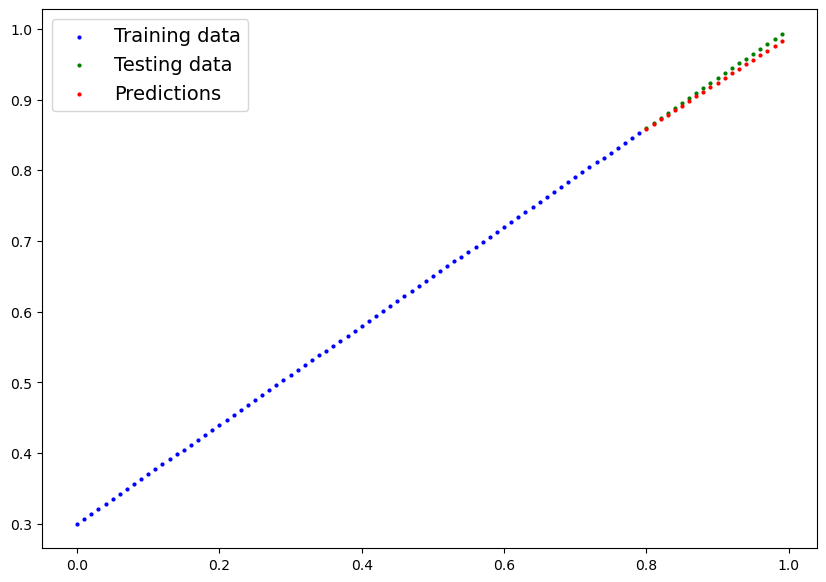

In [160]:
plot_predictions(X_train_regression.cpu(), 
                 y_train_regression.cpu(), 
                 X_test_regression.cpu(), 
                 y_test_regression.cpu(), 
                 y_pred_regression.cpu())

## 6. The missing piece: non-linearity

"What patterns coudl you draw if you were given an infinite amount of infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) amount of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

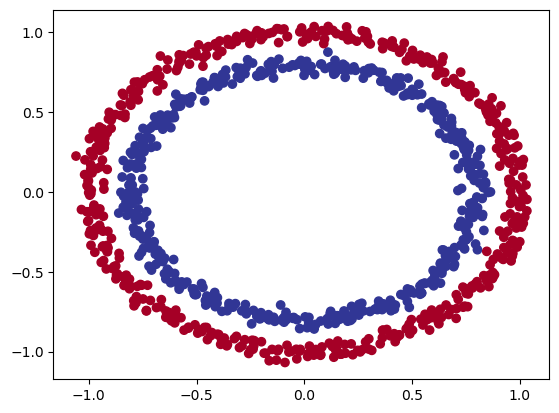

In [217]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [218]:
# Convert data to tensors and train/test split
import torch
from sklearn.model_selection import train_test_split

# Turn data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building model with non-linearity

Artificial neural networks are a large combination of linear and non-linear functions which are potentially able to find patterns in data

In [219]:
from torch import nn
class ClassificationModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Where should we put our non-linear activation function? Between layers
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) # this way speeds up operations

model_2 = ClassificationModelV2().to(device)
model_2
        

ClassificationModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [220]:
# Setup loss and optimizer

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

### 6.3 Training model with non-linearity

In [221]:
# Training loop

# Train model for 1000 epochs
epochs = 1500

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_2.train()

  # 1. Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logit -> prob -> label

  # 2. Calculate loss
  loss = loss_function(y_logits, # BCEWithLogitLoss expects logits as inputs.
                        y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Zero gradients
  model_2.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 50 == 0:

    # Put model in evaluation mode and setup inference context
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))
      # 2. Calculate test loss
      test_loss = loss_function(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train Acc: {acc:.2f} | Test loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train loss: 0.70316 | Train Acc: 0.50 | Test loss: 0.704 | Test Acc: 0.50
Epoch: 50 | Train loss: 0.69192 | Train Acc: 0.52 | Test loss: 0.695 | Test Acc: 0.48
Epoch: 100 | Train loss: 0.68960 | Train Acc: 0.52 | Test loss: 0.693 | Test Acc: 0.47
Epoch: 150 | Train loss: 0.68770 | Train Acc: 0.59 | Test loss: 0.691 | Test Acc: 0.53
Epoch: 200 | Train loss: 0.68574 | Train Acc: 0.63 | Test loss: 0.690 | Test Acc: 0.56
Epoch: 250 | Train loss: 0.68356 | Train Acc: 0.64 | Test loss: 0.688 | Test Acc: 0.56
Epoch: 300 | Train loss: 0.68095 | Train Acc: 0.64 | Test loss: 0.686 | Test Acc: 0.57
Epoch: 350 | Train loss: 0.67773 | Train Acc: 0.64 | Test loss: 0.683 | Test Acc: 0.57
Epoch: 400 | Train loss: 0.67364 | Train Acc: 0.63 | Test loss: 0.680 | Test Acc: 0.58
Epoch: 450 | Train loss: 0.66842 | Train Acc: 0.65 | Test loss: 0.675 | Test Acc: 0.59
Epoch: 500 | Train loss: 0.66177 | Train Acc: 0.69 | Test loss: 0.669 | Test Acc: 0.62
Epoch: 550 | Train loss: 0.65312 | Train Acc: 

### 6.4 Evaluating model trained with non-linear activation functions

In [222]:
# Makes predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

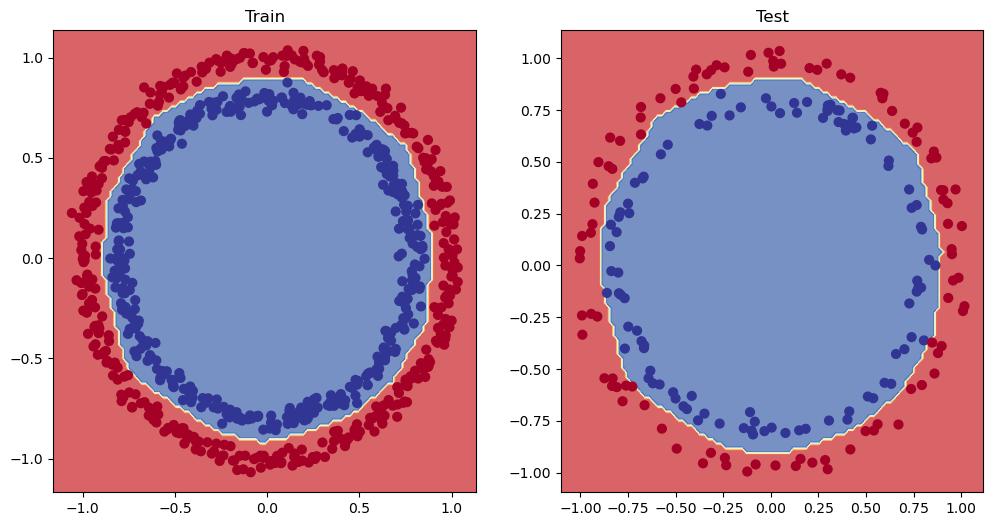

In [223]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)